In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/test.csv


# Importing important libraries

In [2]:
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

# Loading the training dataset

In [3]:
#Reading the file
file = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")

In [4]:
file.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# Checking for null values

In [5]:
file.isnull().sum(axis=0)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

No data cleaning is required since no Null values are found!

In [6]:
file.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

# Data visualization and various conclusions drawn from it

We can create a corelational matrix for all continuous values in the file.

In [7]:
corr = file[['temp','atemp','humidity', 'windspeed','casual', 'registered','count']].corr()

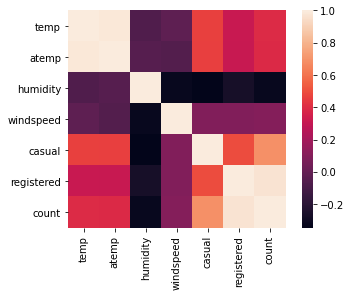

                temp     atemp  humidity  windspeed    casual  registered  \
temp        1.000000  0.984948 -0.064949  -0.017852  0.467097    0.318571   
atemp       0.984948  1.000000 -0.043536  -0.057473  0.462067    0.314635   
humidity   -0.064949 -0.043536  1.000000  -0.318607 -0.348187   -0.265458   
windspeed  -0.017852 -0.057473 -0.318607   1.000000  0.092276    0.091052   
casual      0.467097  0.462067 -0.348187   0.092276  1.000000    0.497250   
registered  0.318571  0.314635 -0.265458   0.091052  0.497250    1.000000   
count       0.394454  0.389784 -0.317371   0.101369  0.690414    0.970948   

               count  
temp        0.394454  
atemp       0.389784  
humidity   -0.317371  
windspeed   0.101369  
casual      0.690414  
registered  0.970948  
count       1.000000  


In [8]:
sb.heatmap(corr,square=True)
plt.show()
print(corr)

We can see that temp and atemp have a very strong positive correlation therefore we can use only temp as a variable without any loss of information. 

We can infer from the correlaton matrix that windspeed has almost no correlation with the casual,registered or count which we wish to predict so we can remove that

What I will attempt to do is make separate models for the casual and the registerd training them separately and then adding the result to get the count.

**Data visualizaton for non continuous variables**

## 1. Season

season
1    100.853686
2    167.804610
3    182.196853
4    170.407462
Name: registered, dtype: float64

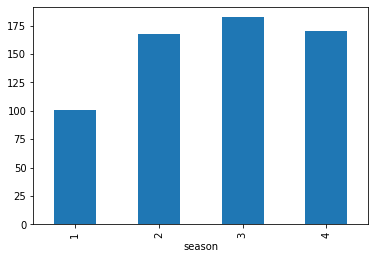

In [9]:
file.groupby('season')['registered'].mean().plot(kind = 'bar')
file.groupby('season')['registered'].mean()

season
1    15.489576
2    47.446762
3    52.220271
4    28.580834
Name: casual, dtype: float64

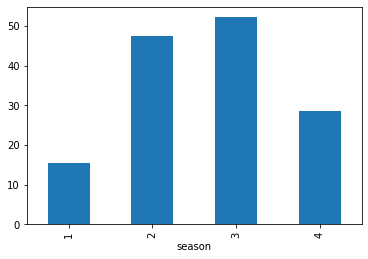

In [10]:
file.groupby('season')['casual'].mean().plot(kind = 'bar')
file.groupby('season')['casual'].mean()

## 2. Holiday

holiday
0    156.094941
1    137.096463
Name: registered, dtype: float64

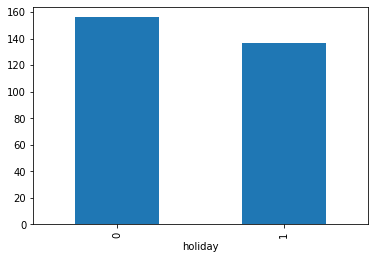

In [11]:
file.groupby('holiday')['registered'].mean().plot(kind='bar')
file.groupby('holiday')['registered'].mean()

holiday
0    35.646714
1    48.781350
Name: casual, dtype: float64

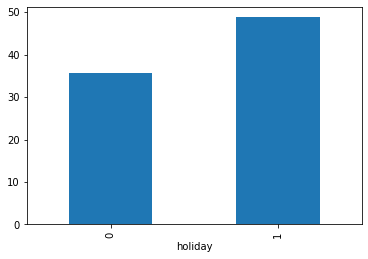

In [12]:
file.groupby('holiday')['casual'].mean().plot(kind='bar')
file.groupby('holiday')['casual'].mean()

Combining the graphs of casual and registered into one of may make it seem like that holiday and have no dependence on count but we can clearly see that holiday increases the casual amount by upto 40% and a same kind of variation is observec in weather so it is reasonable to take two models one for casual and another for registered.The same is obtained from data of working day also.

## 3. Working day

workingday
0    129.198330
1    167.904209
Name: registered, dtype: float64

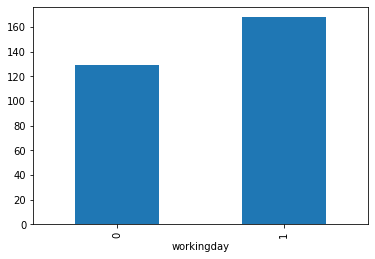

In [13]:
file.groupby('workingday')['registered'].mean().plot(kind='bar')
file.groupby('workingday')['registered'].mean()

workingday
0    59.308290
1    25.107663
Name: casual, dtype: float64

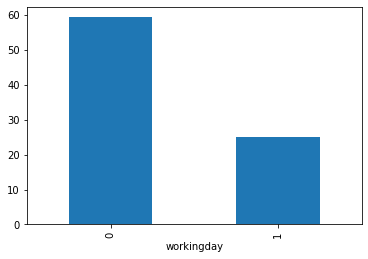

In [14]:
file.groupby('workingday')['casual'].mean().plot(kind='bar')
file.groupby('workingday')['casual'].mean()

## 4. Weather

weather
1    164.928115
2    148.170078
3    101.403958
4    158.000000
Name: registered, dtype: float64

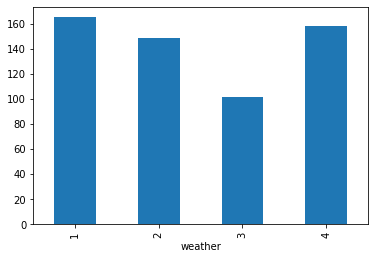

In [15]:
file.groupby('weather')['registered'].mean().plot(kind='bar')
file.groupby('weather')['registered'].mean()

weather
1    40.308676
2    30.785462
3    17.442375
4     6.000000
Name: casual, dtype: float64

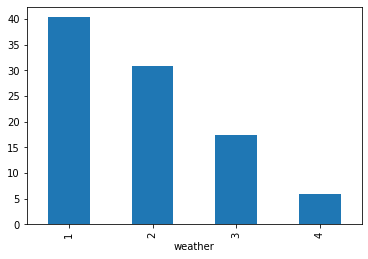

In [16]:
file.groupby('weather')['casual'].mean().plot(kind='bar')
file.groupby('weather')['casual'].mean()

## 5. Date and Time

First we have to separate the individual date and time for each data point into hour,day,month and year.

In [17]:
feed = file
feed['hr'] = pd.DatetimeIndex(feed['datetime']).hour
feed['dy'] = pd.DatetimeIndex(feed['datetime']).day
feed['mth'] = pd.DatetimeIndex(feed['datetime']).month
feed['yr'] = pd.DatetimeIndex(feed['datetime']).year

### 5.a. Hour

hr
0      44.826374
1      27.345815
2      18.080357
3       9.076212
4       5.144796
5      18.311947
6      72.109890
7     202.202198
8     341.226374
9     190.824176
10    128.973626
11    150.621978
12    187.677632
13    183.728070
14    166.853070
15    178.269737
16    241.289474
17    393.324561
18    369.462719
19    266.203947
20    191.785088
21    144.802632
22    110.973684
23     74.046053
Name: registered, dtype: float64

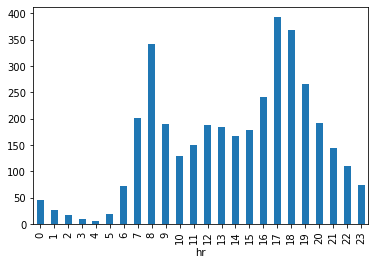

In [18]:
feed.groupby('hr')['registered'].mean().plot(kind='bar')
feed.groupby('hr')['registered'].mean()

hr
0     10.312088
1      6.513216
2      4.819196
3      2.681293
4      1.262443
5      1.455752
6      4.149451
7     10.914286
8     21.542857
9     30.956044
10    46.118681
11    60.052747
12    68.831140
13    74.059211
14    76.589912
15    76.028509
16    75.083333
17    75.440789
18    61.396930
19    49.074561
20    36.732456
21    28.567982
22    22.603070
23    15.462719
Name: casual, dtype: float64

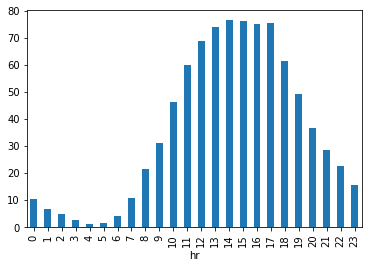

In [19]:
feed.groupby('hr')['casual'].mean().plot(kind='bar')
feed.groupby('hr')['casual'].mean()

### 5.b. Day

dy
1     148.720000
2     149.488656
3     156.106457
4     153.811847
5     154.961739
6     155.748252
7     150.278746
8     145.611498
9     152.866087
10    158.143357
11    159.265845
12    157.225131
13    159.341463
14    160.149826
15    160.965157
16    155.277003
17    164.686957
18    155.214920
19    157.665505
Name: registered, dtype: float64

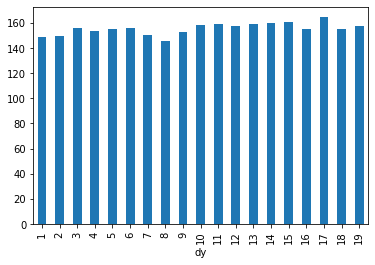

In [20]:
feed.groupby('dy')['registered'].mean().plot(kind='bar')
feed.groupby('dy')['registered'].mean()

dy
1     31.613913
2     34.422339
3     38.589878
4     41.893728
5     34.803478
6     34.111888
7     33.494774
8     33.430314
9     35.031304
10    37.040210
11    36.413732
12    33.450262
13    34.818815
14    35.679443
15    40.562718
16    36.076655
17    40.973913
18    37.390764
19    34.646341
Name: casual, dtype: float64

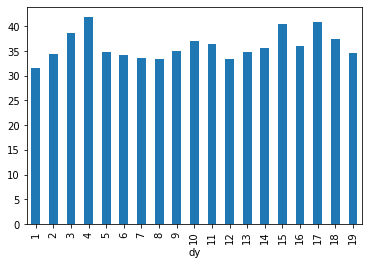

In [21]:
feed.groupby('dy')['casual'].mean().plot(kind='bar')
feed.groupby('dy')['casual'].mean()

### 5.c. Month

mth
1      82.162896
2      99.684795
3     120.360710
4     140.361936
5     174.190789
6     188.770833
7     179.462719
8     183.822368
9     183.309131
10    185.891328
11    165.847420
12    159.495614
Name: registered, dtype: float64

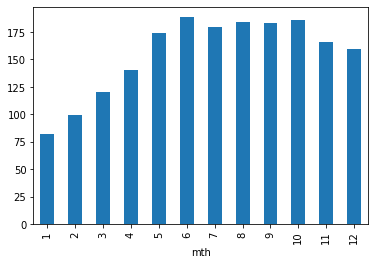

In [22]:
feed.groupby('mth')['registered'].mean().plot(kind='bar')
feed.groupby('mth')['registered'].mean()

mth
1      8.203620
2     10.318535
3     27.809101
4     43.798680
5     45.268640
6     53.260965
7     55.862939
8     50.296053
9     50.496150
10    41.807903
11    27.829857
12    16.118421
Name: casual, dtype: float64

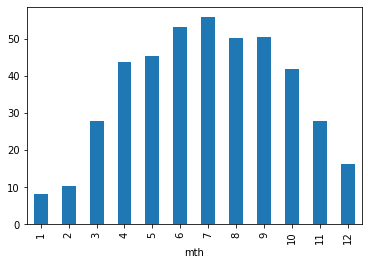

In [23]:
feed.groupby('mth')['casual'].mean().plot(kind='bar')
feed.groupby('mth')['casual'].mean()

### 5.d. Year 

yr
2011    115.485430
2012    195.310944
Name: registered, dtype: float64

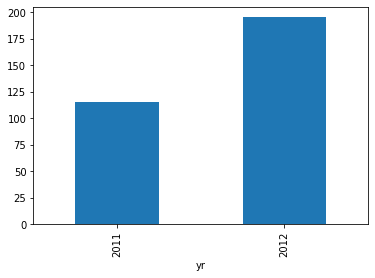

In [24]:
feed.groupby('yr')['registered'].mean().plot(kind='bar')
feed.groupby('yr')['registered'].mean()

yr
2011    28.73792
2012    43.25000
Name: casual, dtype: float64

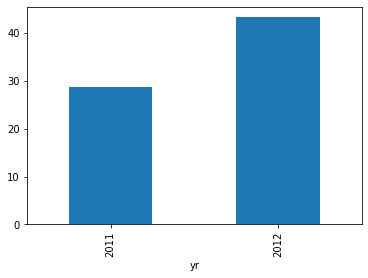

In [25]:
feed.groupby('yr')['casual'].mean().plot(kind='bar')
feed.groupby('yr')['casual'].mean()

From the above graphs we can conclude that te feature cay has hardly any influence over the features registered and count.

In [26]:
feed.describe

<bound method NDFrame.describe of                   datetime  season  holiday  workingday  weather   temp  \
0      2011-01-01 00:00:00       1        0           0        1   9.84   
1      2011-01-01 01:00:00       1        0           0        1   9.02   
2      2011-01-01 02:00:00       1        0           0        1   9.02   
3      2011-01-01 03:00:00       1        0           0        1   9.84   
4      2011-01-01 04:00:00       1        0           0        1   9.84   
...                    ...     ...      ...         ...      ...    ...   
10881  2012-12-19 19:00:00       4        0           1        1  15.58   
10882  2012-12-19 20:00:00       4        0           1        1  14.76   
10883  2012-12-19 21:00:00       4        0           1        1  13.94   
10884  2012-12-19 22:00:00       4        0           1        1  13.94   
10885  2012-12-19 23:00:00       4        0           1        1  13.12   

        atemp  humidity  windspeed  casual  registered  count  hr

In [27]:
feed.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'hr',
       'dy', 'mth', 'yr'],
      dtype='object')

# Adding relevant columns for each of the categorical data columns and removing unnecesary ones

## 1. Season

In [28]:
for i in feed.groupby('season').count().index:
    s = 's'+str(i)
    a=[]
    for j in feed.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    feed[s]=a
feed.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hr,dy,mth,yr,s1,s2,s3,s4
1981,2011-05-09 11:00:00,2,0,1,1,24.60,31.060,46,15.0013,26,99,125,11,9,5,2011,0,1,0,0
10720,2012-12-13 02:00:00,4,0,1,2,10.66,12.120,56,16.9979,3,5,8,2,13,12,2012,0,0,0,1
1309,2011-03-19 10:00:00,1,0,0,1,18.04,21.970,38,27.9993,55,85,140,10,19,3,2011,1,0,0,0
1148,2011-03-12 12:00:00,1,0,0,1,13.94,15.910,53,19.0012,51,107,158,12,12,3,2011,1,0,0,0
2569,2011-06-14 23:00:00,2,0,1,1,22.96,26.515,68,15.0013,19,91,110,23,14,6,2011,0,1,0,0


## 2. Weather 

In [29]:
for i in feed.groupby('weather').count().index:
    s = 'w'+str(i)
    a=[]
    for j in feed.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    feed[s]=a
feed.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,mth,yr,s1,s2,s3,s4,w1,w2,w3,w4
4499,2011-10-19 13:00:00,4,0,1,2,22.14,25.760,94,19.0012,20,...,10,2011,0,0,0,1,0,1,0,0
1539,2011-04-10 00:00:00,2,0,0,2,15.58,19.695,87,6.0032,5,...,4,2011,0,1,0,0,0,1,0,0
8855,2012-08-11 08:00:00,3,0,0,1,27.06,30.305,83,7.0015,30,...,8,2012,0,0,1,0,1,0,0,0
1994,2011-05-10 00:00:00,2,0,1,1,19.68,23.485,63,0.0000,6,...,5,2011,0,1,0,0,1,0,0,0
5999,2012-02-06 05:00:00,1,0,1,1,7.38,10.605,80,7.0015,0,...,2,2012,1,0,0,0,1,0,0,0


## 3. Hour

In [30]:
for i in feed.groupby('hr').count().index:
    s = 'hr'+str(i)
    a=[]
    for j in feed.hr:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    feed[s]=a
feed.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hr14,hr15,hr16,hr17,hr18,hr19,hr20,hr21,hr22,hr23
5279,2011-12-14 01:00:00,4,0,1,1,10.66,15.15,75,0.0000,0,...,0,0,0,0,0,0,0,0,0,0
4837,2011-11-14 15:00:00,4,0,1,1,26.24,31.06,44,22.0028,53,...,0,1,0,0,0,0,0,0,0,0
6809,2012-04-02 00:00:00,2,0,1,3,18.04,21.97,82,7.0015,6,...,0,0,0,0,0,0,0,0,0,0
6016,2012-02-06 22:00:00,1,0,1,1,12.30,15.15,65,8.9981,4,...,0,0,0,0,0,0,0,0,1,0
8673,2012-08-03 18:00:00,3,0,1,2,33.62,40.15,59,16.9979,98,...,0,0,0,0,1,0,0,0,0,0


## 4.Month

In [31]:
for i in feed.groupby("mth").count().index:
    s = 'm' + str(i)
    a = []
    for j in feed.mth:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    feed[s] = a
feed.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
5827,2012-01-18 00:00:00,1,0,1,2,18.86,22.725,77,22.0028,3,...,0,0,0,0,0,0,0,0,0,0
5243,2011-12-12 13:00:00,4,0,1,2,12.30,15.910,52,7.0015,13,...,0,0,0,0,0,0,0,0,0,1
10119,2012-11-07 00:00:00,4,0,1,2,12.30,14.395,56,19.0012,49,...,0,0,0,0,0,0,0,0,1,0
343,2011-01-15 19:00:00,1,0,0,2,13.12,15.150,39,16.9979,14,...,0,0,0,0,0,0,0,0,0,0
6862,2012-04-04 06:00:00,2,0,1,2,17.22,21.210,58,0.0000,6,...,0,1,0,0,0,0,0,0,0,0


In [32]:
feed.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'hr',
       'dy', 'mth', 'yr', 's1', 's2', 's3', 's4', 'w1', 'w2', 'w3', 'w4',
       'hr0', 'hr1', 'hr2', 'hr3', 'hr4', 'hr5', 'hr6', 'hr7', 'hr8', 'hr9',
       'hr10', 'hr11', 'hr12', 'hr13', 'hr14', 'hr15', 'hr16', 'hr17', 'hr18',
       'hr19', 'hr20', 'hr21', 'hr22', 'hr23', 'm1', 'm2', 'm3', 'm4', 'm5',
       'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'],
      dtype='object')

## Removing unnecessary columns

In [33]:
feed = feed[['hr0','hr1','hr2','hr3','hr4','hr5','hr6','hr7','hr8','hr9','hr10','hr11','hr12','hr13','hr14','hr15','hr16','hr17','hr18',
                 'hr19','hr20','hr21','hr22','hr23','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','yr',
                 's1','s2','s3','s4','holiday','workingday','w1','w2','w3','w4','temp','humidity','casual','registered']]

In [34]:
feed.describe

<bound method NDFrame.describe of        hr0  hr1  hr2  hr3  hr4  hr5  hr6  hr7  hr8  hr9  ...  holiday  \
0        1    0    0    0    0    0    0    0    0    0  ...        0   
1        0    1    0    0    0    0    0    0    0    0  ...        0   
2        0    0    1    0    0    0    0    0    0    0  ...        0   
3        0    0    0    1    0    0    0    0    0    0  ...        0   
4        0    0    0    0    1    0    0    0    0    0  ...        0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...      ...   
10881    0    0    0    0    0    0    0    0    0    0  ...        0   
10882    0    0    0    0    0    0    0    0    0    0  ...        0   
10883    0    0    0    0    0    0    0    0    0    0  ...        0   
10884    0    0    0    0    0    0    0    0    0    0  ...        0   
10885    0    0    0    0    0    0    0    0    0    0  ...        0   

       workingday  w1  w2  w3  w4   temp  humidity  casual  registered  
0               

# Preparing training and testing sets

### 1. Training set

In [35]:
df_train_x = feed.drop('casual',axis = 1).drop('registered',axis=1)
df_train_x.describe

<bound method NDFrame.describe of        hr0  hr1  hr2  hr3  hr4  hr5  hr6  hr7  hr8  hr9  ...  s3  s4  holiday  \
0        1    0    0    0    0    0    0    0    0    0  ...   0   0        0   
1        0    1    0    0    0    0    0    0    0    0  ...   0   0        0   
2        0    0    1    0    0    0    0    0    0    0  ...   0   0        0   
3        0    0    0    1    0    0    0    0    0    0  ...   0   0        0   
4        0    0    0    0    1    0    0    0    0    0  ...   0   0        0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..      ...   
10881    0    0    0    0    0    0    0    0    0    0  ...   0   1        0   
10882    0    0    0    0    0    0    0    0    0    0  ...   0   1        0   
10883    0    0    0    0    0    0    0    0    0    0  ...   0   1        0   
10884    0    0    0    0    0    0    0    0    0    0  ...   0   1        0   
10885    0    0    0    0    0    0    0    0    0    0  ...   0   1       

### 2. Training set

In [36]:
df_reg_train_y = feed['registered']
df_reg_train_y.describe

<bound method NDFrame.describe of 0         13
1         32
2         27
3         10
4          1
        ... 
10881    329
10882    231
10883    164
10884    117
10885     84
Name: registered, Length: 10886, dtype: int64>

In [37]:
df_cas_train_y = feed['casual']
df_cas_train_y.describe

<bound method NDFrame.describe of 0         3
1         8
2         5
3         3
4         0
         ..
10881     7
10882    10
10883     4
10884    12
10885     4
Name: casual, Length: 10886, dtype: int64>

# Machine learning model

### Splitting data into train and test sets

In [38]:
x1_train, x1_test, y1_train, y1_test = train_test_split(df_train_x, df_cas_train_y, test_size=0.15, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(df_train_x, df_reg_train_y, test_size=0.15, random_state=42)

### Using polynomial on the dataset

In [39]:
poly = PolynomialFeatures(degree=2)
poly_x1_train = poly.fit_transform(x1_train)
poly_x1_test = poly.fit_transform(x1_test)
poly_x2_train = poly.fit_transform(x2_train)
poly_x2_test = poly.fit_transform(x2_test)

### Trying different models to see which one works best for the given data.

In [40]:
predict1=[]
for i in range (0,60,5):
    dt = RandomForestRegressor(n_estimators = 100,max_depth=i+1).fit(x1_train, y1_train)
    pre_dt = dt.predict(x1_test)
    predict1.append(pre_dt)
i=0
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (i*5+1)+" : "+str(np.sqrt(mean_squared_log_error( y1_test, pre ))))
    i+=1

1 : 1.5588335909799573
6 : 1.0877222654801082
11 : 0.8671210974590496
16 : 0.7316776192462918
21 : 0.6682543848686607
26 : 0.6490084399403926
31 : 0.6469975089692357
36 : 0.6488423437487851
41 : 0.6516801492886238
46 : 0.6531384144975823
51 : 0.6495255264978685
56 : 0.6530501551816081


We can see that the minimum must occur between i=21 and 1=41

In [41]:
predict1=[]
for i in range (20,40,2):
    dt = RandomForestRegressor(n_estimators = 100,max_depth=i+1).fit(x1_train, y1_train)
    pre_dt = dt.predict(x1_test)
    predict1.append(pre_dt)
i=20
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (i*2+1)+" : "+str(np.sqrt(mean_squared_log_error( y1_test, pre ))))
    i+=1

41 : 0.668170099615972
43 : 0.6600143684719203
45 : 0.6544470621358706
47 : 0.6518873572425985
49 : 0.648769500956988
51 : 0.6514942877609873
53 : 0.6558001312728237
55 : 0.6477730554423222
57 : 0.6503310914648821
59 : 0.6493047187924744


We can conclude that the optimal value for depth = 50 for the random forest after which it starts to overfit for casual.

**P.S: The actual minimum values may vary from instance to instance due to the randomness in the trees generated however the optimal depth will be more or less the same compared to the optimal chosen value**

In [42]:
predict1=[]
for i in range (0,70,5):
    dt = RandomForestRegressor(n_estimators=100,max_depth=i+1).fit(x2_train, y2_train)
    pre_dt = dt.predict(x2_test)
    predict1.append(pre_dt)
i=0
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (5*i+1)+" : "+str(np.sqrt(mean_squared_log_error( y2_test, pre ))))
    i+=1

1 : 1.556906527868858
6 : 1.337039469744858
11 : 0.9959762787405447
16 : 0.6779722584361657
21 : 0.5010659940661539
26 : 0.423953307868524
31 : 0.41618367118840466
36 : 0.417449518969457
41 : 0.41813718793207927
46 : 0.41663371253854037
51 : 0.4143086273543202
56 : 0.41480211701060266
61 : 0.41773503605060575
66 : 0.4094284591632525


We can see that the minimum must occur between i = 56  and i = 66

In [43]:
predict1=[]
for i in range (55,65,1):
    dt = RandomForestRegressor(n_estimators = 100,max_depth=i+1).fit(x2_train, y2_train)
    pre_dt = dt.predict(x2_test)
    predict1.append(pre_dt)
i=55
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (i+1)+" : "+str(np.sqrt(mean_squared_log_error( y2_test, pre ))))
    i+=1

56 : 0.41116478559322306
57 : 0.4169816012584681
58 : 0.41892973917001114
59 : 0.42265523819584866
60 : 0.41022168346505444
61 : 0.41839749914358526
62 : 0.4172234509464982
63 : 0.41383311406631423
64 : 0.4142616761396202
65 : 0.4155007577894159


We can conclude that the optimal value for depth = 60 for the random forest after which it starts to overfit for registered.

**P.S: The actual minimum values may vary from instance to instance due to the randomness in the trees generated however the optimal depth will be more or less the same compared to the optimal chosen value**

In [44]:
predict1 = []

reg1 = LinearRegression().fit(x1_train, y1_train)
pre_reg1 = reg1.predict(x1_test)

reg1_poly = LinearRegression().fit(poly_x1_train, y1_train)
pre_reg1_poly = reg1_poly.predict(poly_x1_test)

rf1 = RandomForestRegressor(n_estimators = 100,max_depth=50).fit(x1_train, y1_train)
pre_rf1 = rf1.predict(x1_test)

predict1.append(pre_reg1)
predict1.append(pre_reg1_poly)
predict1.append(pre_rf1)

for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(1)
        else:
            pre.append(p)
    print(np.sqrt(mean_squared_log_error( y1_test, pre )))

1.023731513297351
0.8942442901178272
0.6481364136185888


Since we know that the output is never less than 1 we replace all negative values with 1 before appending in pre to calculate error.

In [45]:
pd.DataFrame(pre_reg1,columns = ['casual']).describe()

,casual
count,1633.000000
mean,35.149014
std,38.112969
min,-59.992920
25%,7.695312
50%,33.443848
75%,62.923340
max,140.464844


In [46]:
predict2 = []

reg2 = LinearRegression().fit(x2_train, y2_train)
pre_reg2 = reg2.predict(x2_test)

reg2_poly = LinearRegression().fit(poly_x2_train, y2_train)
pre_reg2_poly = reg2_poly.predict(poly_x2_test)

rf2 = RandomForestRegressor(n_estimators = 100,max_depth=60).fit(x2_train, y2_train)
pre_rf2 = rf2.predict(x2_test)

predict2.append(pre_reg2)
predict2.append(pre_reg2_poly)
predict2.append(pre_rf2)

for prediction in predict2:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(1)
        else:
            pre.append(p)
    print(np.sqrt(mean_squared_log_error( y2_test, pre )))

1.0057735958513363
0.6590436188670552
0.4130877258732721


Since we know that the output is never less than 1 we replace all negative values with 1 before appending in pre to calculate error.

In [47]:
pd.DataFrame(pre_reg2,columns = ['registered']).describe()

,registered
count,1633.000000
mean,150.860613
std,122.663435
min,-142.786621
25%,60.552734
50%,142.763184
75%,229.649902
max,488.712891


Clearly the random forest model works best in this situation.

### Retraining the decision tree over the whole dataset for submission.

In [48]:
rf1 = RandomForestRegressor(max_depth = 50).fit(df_train_x,df_cas_train_y)
rf2 = RandomForestRegressor(max_depth = 60).fit(df_train_x,df_reg_train_y)

### Reading the test file

In [49]:
test_file = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [50]:
test=test_file
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


## Processing of the test file

In [51]:
test['mth'] = pd.DatetimeIndex(test['datetime']).month
test['yr'] = pd.DatetimeIndex(test['datetime']).year
test['dy'] = pd.DatetimeIndex(test['datetime']).day
test['hr'] = pd.DatetimeIndex(test['datetime']).hour

for i in test.groupby("season").count().index:
    s = 's' + str(i)
    a = []
    for j in test.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
for i in test.groupby("weather").count().index:
    s = 'w' + str(i)
    a = []
    for j in test.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
for i in test.groupby('hr').count().index:
    s = 'hr'+str(i)
    a=[]
    for j in test.hr:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s]=a
for i in test.groupby("mth").count().index:
    s = 'm' + str(i)
    a = []
    for j in test.mth:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
test.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,mth,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
6007,2012-11-22 15:00:00,4,1,0,1,19.68,23.485,29,0.0000,11,...,0,0,0,0,0,0,0,0,1,0
246,2011-01-31 13:00:00,1,0,1,2,6.56,11.365,59,0.0000,1,...,0,0,0,0,0,0,0,0,0,0
4063,2012-04-21 03:00:00,2,0,0,1,20.50,24.240,82,15.0013,4,...,0,1,0,0,0,0,0,0,0,0
5942,2012-10-31 22:00:00,4,0,1,1,14.76,17.425,57,8.9981,10,...,0,0,0,0,0,0,0,1,0,0
1164,2011-05-26 12:00:00,2,0,1,1,31.98,37.120,59,22.0028,5,...,0,0,1,0,0,0,0,0,0,0
1533,2011-06-29 21:00:00,3,0,1,1,29.52,32.575,39,15.0013,6,...,0,0,0,1,0,0,0,0,0,0
6260,2012-12-22 05:00:00,1,0,0,1,10.66,11.365,48,27.9993,12,...,0,0,0,0,0,0,0,0,0,1
5989,2012-11-21 21:00:00,4,0,1,1,14.76,18.940,50,0.0000,11,...,0,0,0,0,0,0,0,0,1,0
5766,2012-10-23 02:00:00,4,0,1,1,18.04,21.970,88,8.9981,10,...,0,0,0,0,0,0,0,1,0,0
3731,2012-02-29 07:00:00,1,0,1,2,10.66,13.635,81,8.9981,2,...,0,0,0,0,0,0,0,0,0,0


In [52]:
test = test[['hr0','hr1','hr2','hr3','hr4','hr5','hr6','hr7','hr8','hr9','hr10','hr11','hr12','hr13','hr14','hr15','hr16','hr17','hr18',
                 'hr19','hr20','hr21','hr22','hr23','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','yr',
                 's1','s2','s3','s4','holiday','workingday','w1','w2','w3','w4','temp','humidity']]
test.describe

<bound method NDFrame.describe of       hr0  hr1  hr2  hr3  hr4  hr5  hr6  hr7  hr8  hr9  ...  s3  s4  holiday  \
0       1    0    0    0    0    0    0    0    0    0  ...   0   0        0   
1       0    1    0    0    0    0    0    0    0    0  ...   0   0        0   
2       0    0    1    0    0    0    0    0    0    0  ...   0   0        0   
3       0    0    0    1    0    0    0    0    0    0  ...   0   0        0   
4       0    0    0    0    1    0    0    0    0    0  ...   0   0        0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..      ...   
6488    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6489    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6490    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6491    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6492    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   

     

## Predicting the output over test set

In [53]:
pre_cas = rf1.predict(test)
pre_reg = rf2.predict(test)
final_predictions = pd.DataFrame(pre_cas+pre_reg,columns = ['cout'])

final_predictions.describe

<bound method NDFrame.describe of             cout
0      12.318333
1       4.880000
2       3.860000
3       3.790000
4       2.878000
...          ...
6488  225.010000
6489  145.920000
6490  121.270000
6491   98.570000
6492   59.921333

[6493 rows x 1 columns]>

In [54]:
s=[]
for j in final_predictions.cout:
    if int(j)<1:
        s.append(1)
    else:
        s.append(j)
final_predictions['count'] = s 

**Since we know that the output is never less than 1 we have to replace all negative values with 1.**

In [55]:
final_predictions.describe

<bound method NDFrame.describe of             cout       count
0      12.318333   12.318333
1       4.880000    4.880000
2       3.860000    3.860000
3       3.790000    3.790000
4       2.878000    2.878000
...          ...         ...
6488  225.010000  225.010000
6489  145.920000  145.920000
6490  121.270000  121.270000
6491   98.570000   98.570000
6492   59.921333   59.921333

[6493 rows x 2 columns]>

In [56]:
final_predictions['datetime']=test_file['datetime']
final_predictions = final_predictions[['datetime','count']]

In [57]:
final_predictions.describe()

,count
count,6493.000000
mean,191.098547
std,171.672983
min,1.315000
25%,52.632500
50%,149.328333
75%,281.643000
max,926.750000


## Exporting output to csv

In [58]:
final_predictions.to_csv('submission.csv',index=False)